In [1]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Dataset & dataloader

In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [14]:
bs = 128
crop_size = 128

train_transform = transforms.Compose([
    transforms.RandomRotation(90),
    transforms.RandomRotation(45),
    transforms.ColorJitter(brightness=0.3),
    transforms.RandomAffine(0, translate=(0.3, 0.3)),
    transforms.RandomResizedCrop(crop_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(140),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder("data/train/", transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=4)

test_set = datasets.ImageFolder("data/test/", transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

In [15]:
feature, target = next(iter(trainloader))
feature.shape

torch.Size([128, 3, 128, 128])

In [16]:
label = train_set.classes
label

['paper', 'rock', 'scissors']

# Arsitektur & Config 

In [17]:
from jcopdl.layers import conv_block, linear_block

In [18]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            conv_block(3, 8),
            conv_block(8, 16), 
            conv_block(16, 32),
            conv_block(32, 64),
            conv_block(64, 128), 
            nn.Flatten()
        )
        
        self.fc = nn.Sequential(
            linear_block(2048, 1024, dropout=0.25),
            linear_block(1024, 512, dropout=0.25),
            linear_block(512, 256, dropout=0.25),
            linear_block(256, 3, activation="lsoftmax")
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

config = set_config({
    "batch_size": bs,
    "crop_size": crop_size
})

# Training Preparation -> MCOC

In [22]:
model = CNN().to(device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model/model1")

# Training

In [23]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc



Epoch     1
Train_cost  = 1.1011 | Test_cost  = 1.0985 | Train_score = 0.3150 | Test_score = 0.3326 |




Epoch     2
Train_cost  = 1.0989 | Test_cost  = 1.0982 | Train_score = 0.3373 | Test_score = 0.3417 |




Epoch     3
Train_cost  = 1.0985 | Test_cost  = 1.0984 | Train_score = 0.3345 | Test_score = 0.3417 |
==> EarlyStop patience =  1 | Best test_score: 0.3417




Epoch     4
Train_cost  = 1.0982 | Test_cost  = 1.0971 | Train_score = 0.3431 | Test_score = 0.3417 |
==> EarlyStop patience =  2 | Best test_score: 0.3417




Epoch     5
Train_cost  = 1.0922 | Test_cost  = 1.0630 | Train_score = 0.3819 | Test_score = 0.5877 |




Epoch     6
Train_cost  = 1.0260 | Test_cost  = 1.1778 | Train_score = 0.5054 | Test_score = 0.3326 |
==> EarlyStop patience =  1 | Best test_score: 0.5877




Epoch     7
Train_cost  = 1.0996 | Test_cost  = 1.0175 | Train_score = 0.3596 | Test_score = 0.5034 |
==> EarlyStop patience =  2 | Best test_score: 0.5877




Epoch     8
Train_cost  = 0.9938 | Test_cost  = 0.8776 | Train_score = 0.5180 | Test_score = 0.6333 |




Epoch     9
Train_cost  = 0.8871 | Test_cost  = 0.9877 | Train_score = 0.5923 | Test_score = 0.4875 |
==> EarlyStop patience =  1 | Best test_score: 0.6333




Epoch    10
Train_cost  = 0.8227 | Test_cost  = 0.7205 | Train_score = 0.6175 | Test_score = 0.6811 |




Epoch    11
Train_cost  = 0.6761 | Test_cost  = 0.6726 | Train_score = 0.6752 | Test_score = 0.6743 |
==> EarlyStop patience =  1 | Best test_score: 0.6811




Epoch    12
Train_cost  = 0.6285 | Test_cost  = 0.4876 | Train_score = 0.7227 | Test_score = 0.8588 |




Epoch    13
Train_cost  = 0.5982 | Test_cost  = 0.4726 | Train_score = 0.7513 | Test_score = 0.7973 |
==> EarlyStop patience =  1 | Best test_score: 0.8588




Epoch    14
Train_cost  = 0.5082 | Test_cost  = 0.3334 | Train_score = 0.8090 | Test_score = 0.9089 |




Epoch    15
Train_cost  = 0.5047 | Test_cost  = 0.3862 | Train_score = 0.7919 | Test_score = 0.8884 |
==> EarlyStop patience =  1 | Best test_score: 0.9089




Epoch    16
Train_cost  = 0.4381 | Test_cost  = 0.3611 | Train_score = 0.8462 | Test_score = 0.8610 |
==> EarlyStop patience =  2 | Best test_score: 0.9089




Epoch    17
Train_cost  = 0.3562 | Test_cost  = 0.2396 | Train_score = 0.8782 | Test_score = 0.9294 |




Epoch    18
Train_cost  = 0.4100 | Test_cost  = 0.2274 | Train_score = 0.8502 | Test_score = 0.9226 |
==> EarlyStop patience =  1 | Best test_score: 0.9294




Epoch    19
Train_cost  = 0.2814 | Test_cost  = 0.1291 | Train_score = 0.9108 | Test_score = 0.9636 |




Epoch    20
Train_cost  = 0.2243 | Test_cost  = 0.4687 | Train_score = 0.9297 | Test_score = 0.8246 |


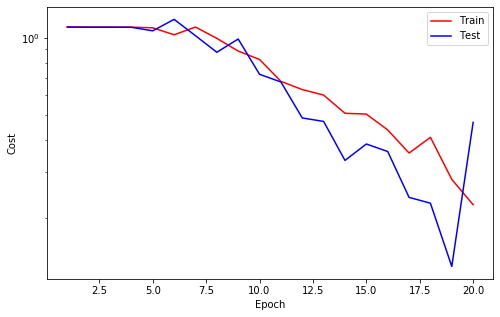

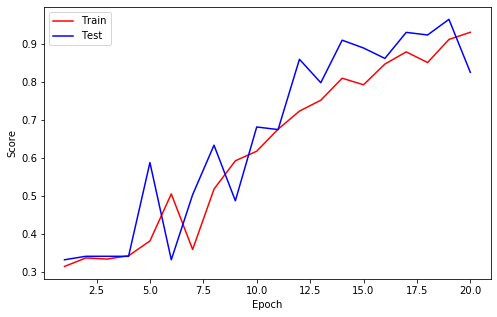

==> EarlyStop patience =  1 | Best test_score: 0.9636




Epoch    21
Train_cost  = 0.2254 | Test_cost  = 0.3959 | Train_score = 0.9228 | Test_score = 0.8952 |
==> EarlyStop patience =  2 | Best test_score: 0.9636




Epoch    22
Train_cost  = 0.2278 | Test_cost  = 0.1575 | Train_score = 0.9228 | Test_score = 0.9362 |
==> EarlyStop patience =  3 | Best test_score: 0.9636




Epoch    23
Train_cost  = 0.2550 | Test_cost  = 0.1131 | Train_score = 0.9108 | Test_score = 0.9681 |




Epoch    24
Train_cost  = 0.2386 | Test_cost  = 0.1433 | Train_score = 0.9137 | Test_score = 0.9522 |
==> EarlyStop patience =  1 | Best test_score: 0.9681




Epoch    25
Train_cost  = 0.1632 | Test_cost  = 0.2787 | Train_score = 0.9480 | Test_score = 0.8838 |
==> EarlyStop patience =  2 | Best test_score: 0.9681




Epoch    26
Train_cost  = 0.1587 | Test_cost  = 0.1351 | Train_score = 0.9491 | Test_score = 0.9522 |
==> EarlyStop patience =  3 | Best test_score: 0.9681




Epoch    27
Train_cost  = 0.1730 | Test_cost  = 0.0833 | Train_score = 0.9457 | Test_score = 0.9704 |




Epoch    28
Train_cost  = 0.1424 | Test_cost  = 0.1260 | Train_score = 0.9554 | Test_score = 0.9453 |
==> EarlyStop patience =  1 | Best test_score: 0.9704




Epoch    29
Train_cost  = 0.1301 | Test_cost  = 0.2791 | Train_score = 0.9640 | Test_score = 0.8952 |
==> EarlyStop patience =  2 | Best test_score: 0.9704




Epoch    30
Train_cost  = 0.1275 | Test_cost  = 0.0797 | Train_score = 0.9611 | Test_score = 0.9727 |




Epoch    31
Train_cost  = 0.2887 | Test_cost  = 0.3420 | Train_score = 0.8885 | Test_score = 0.8314 |
==> EarlyStop patience =  1 | Best test_score: 0.9727




Epoch    32
Train_cost  = 0.2168 | Test_cost  = 0.1106 | Train_score = 0.9245 | Test_score = 0.9749 |




Epoch    33
Train_cost  = 0.1304 | Test_cost  = 0.2217 | Train_score = 0.9634 | Test_score = 0.9157 |
==> EarlyStop patience =  1 | Best test_score: 0.9749




Epoch    34
Train_cost  = 0.1360 | Test_cost  = 0.0797 | Train_score = 0.9605 | Test_score = 0.9795 |




Epoch    35
Train_cost  = 0.1247 | Test_cost  = 0.1490 | Train_score = 0.9577 | Test_score = 0.9431 |
==> EarlyStop patience =  1 | Best test_score: 0.9795




Epoch    36
Train_cost  = 0.1268 | Test_cost  = 0.0755 | Train_score = 0.9646 | Test_score = 0.9772 |
==> EarlyStop patience =  2 | Best test_score: 0.9795




Epoch    37
Train_cost  = 0.1101 | Test_cost  = 0.0934 | Train_score = 0.9657 | Test_score = 0.9658 |
==> EarlyStop patience =  3 | Best test_score: 0.9795




Epoch    38
Train_cost  = 0.0823 | Test_cost  = 0.0645 | Train_score = 0.9748 | Test_score = 0.9749 |
==> EarlyStop patience =  4 | Best test_score: 0.9795




Epoch    39
Train_cost  = 0.1312 | Test_cost  = 0.0757 | Train_score = 0.9611 | Test_score = 0.9749 |
==> EarlyStop patience =  5 | Best test_score: 0.9795
==> Execute Early Stopping at epoch: 39 | Best test_score: 0.9795
==> Best model is saved at model/model1


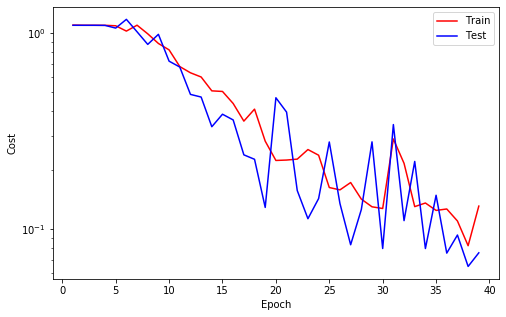

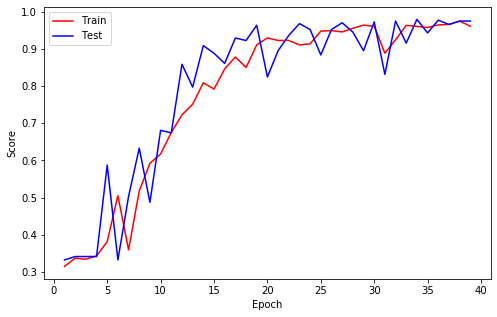

In [24]:
while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost, train_score, test_score)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

In [25]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

In [26]:
with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = output.argmax(1)
preds

tensor([0, 1, 1, 1, 0, 2, 0, 0, 1, 2, 0, 2, 0, 1, 1, 0, 1, 1, 0, 1, 2, 1, 2, 2,
        1, 1, 1, 2, 1, 0, 0, 0, 1, 1, 2, 1, 0, 0, 0, 0, 1, 2, 0, 1, 1, 2, 1, 1,
        2, 2, 2, 1, 1, 0, 0, 2, 0, 0, 1, 1, 0, 0, 2, 0, 1, 0, 1, 0, 0, 1, 2, 1,
        2, 1, 2, 0, 0, 2, 1, 0, 2, 0, 2, 2, 2, 1, 2, 2, 2, 0, 2, 1, 0, 0, 0, 0,
        2, 0, 2, 2, 1, 1, 2, 1, 0, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 0,
        1, 1, 2, 0, 1, 2, 2, 2], device='cuda:0')

In [27]:
import matplotlib.pyplot as plt

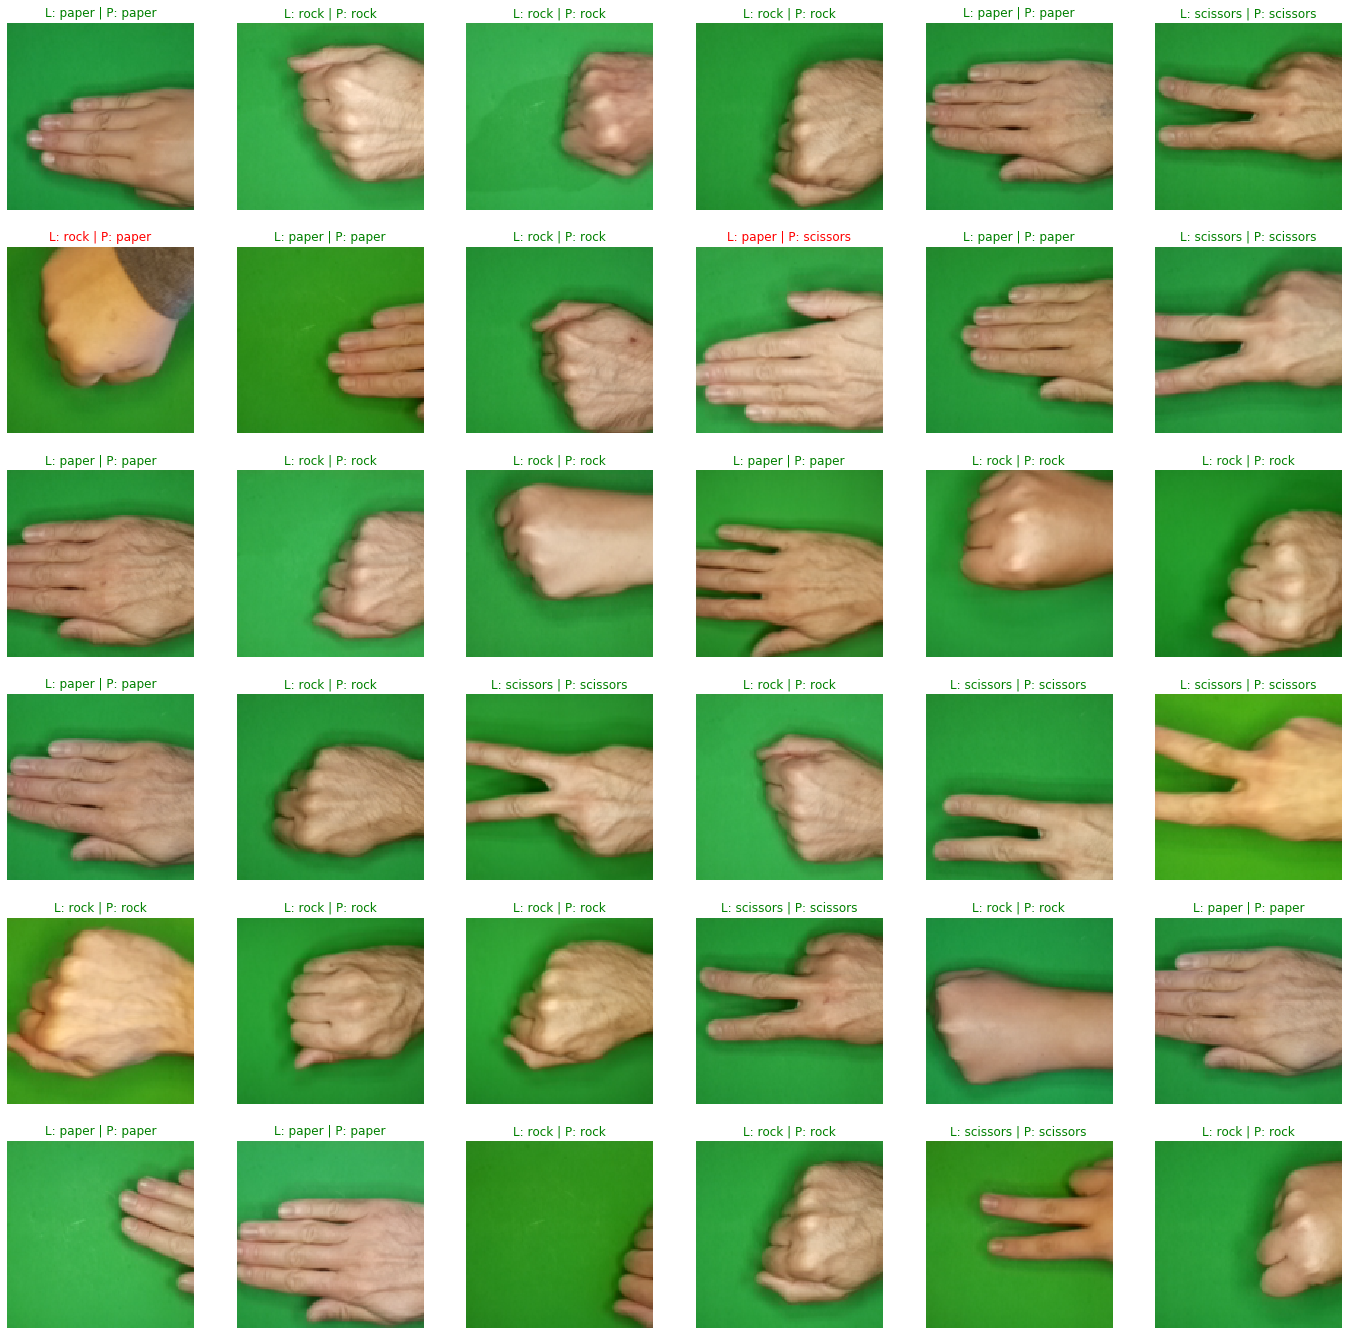

In [28]:
fig, axes = plt.subplots(6, 6, figsize=(24, 24))
for image, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(image.permute(1, 2, 0).cpu())
    font = {"color": 'r'} if label != pred else {"color": 'g'}        
    label, pred = train_set.classes[label.item()], train_set.classes[pred.item()]
    ax.set_title(f"L: {label} | P: {pred}", fontdict=font);
    ax.axis('off');